# <span style="color: blue;">Test Growth of R. cellulolyticum CarveMe model on various basic growth media with simple sugars. </span>

#### Importing tools

In [1]:
from reframed import pFBA, Environment, FVA, FBA, load_cbmodel, plot_flux_envelope, gene_knockout
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Loading model

In [2]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')
draft = load_cbmodel('../models/RcH10_draft.xml', flavor='bigg')

## <span style="color: blue;">A: Testing basic functionality. </span>

### Growth on media used during CarveMe reconstruction

**Motivation**: Ensuring that the model is still able to grow on the media that literature states that it should be able to grow on. 

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')

In [4]:
media = media.groupby('medium').agg({'compound': set})

In [5]:
growth_final = {}
growth_draft = {}

for medium_id, cpds in media.iterrows():
    env = Environment.from_compounds(cpds['compound']).apply(model, exclusive=True, inplace=False, warning=False)
    sol = FBA(model, constraints=env)
    growth_final[medium_id]=sol.fobj
    
    env = Environment.from_compounds(cpds['compound']).apply(draft, exclusive=True, inplace=False, warning=False)
    sol = FBA(draft, constraints=env)
    growth_draft[medium_id]=sol.fobj

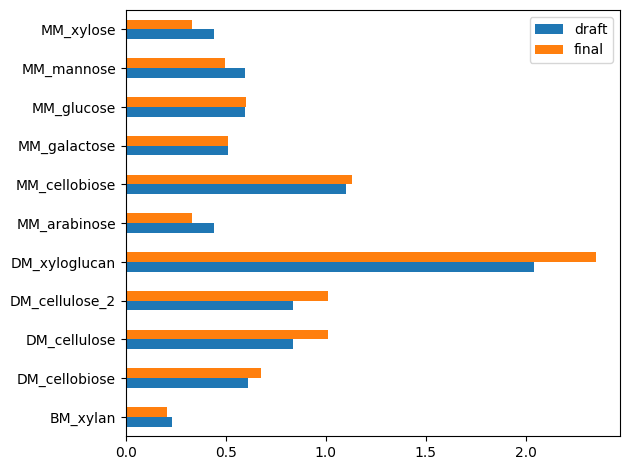

In [6]:
df = pd.DataFrame({'draft':growth_draft, 'final':growth_final})
df.plot.barh()
plt.tight_layout()
plt.savefig('../figures/growth_on_carbon_sources.png', dpi=300)

### Determining the existence of energy producing cycles in the model. 

In [7]:
constraints = Environment.empty(model)
constraints['R_ATPM'] = (0, 1000)
sol = FBA(model, objective={'R_ATPM': 1}, constraints=constraints)
print(sol)

Objective: 0.0
Status: Optimal



### Production envelopes for various fermentation products.

NameError: name 'q_etoh' is not defined

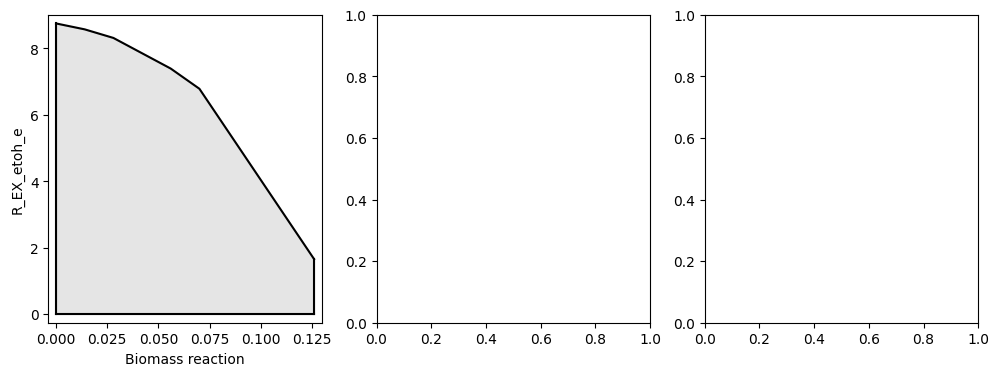

In [8]:
env_cellb = Environment.from_compounds(media.loc['DM_cellobiose', 'compound'])
env_cellb.apply(model, exclusive=True, inplace=True, warning=False)

q_cellb = 1.98

fig, axs = plt.subplots(1,3, figsize=(12,4))

plot_flux_envelope(model,'Growth','R_EX_etoh_e', constraints={'R_EX_cellb_e': (-q_cellb, 0)}, ax=axs[0])
axs[0].axhline(y = q_etoh, color = 'r', linestyle = '-.', label="Experimental result")

plot_flux_envelope(model,'Growth','R_EX_lac__L_e', constraints={'R_EX_cellb_e': (-q_cellb, 0)}, ax=axs[1])
axs[1].axhline(y = q_lac, color = 'r', linestyle = '-.', label="Experimental result")

plot_flux_envelope(model,'Growth','R_EX_ac_e', constraints={'R_EX_cellb_e': (-q_cellb, 0)}, ax=axs[2])
axs[2].axhline(y = q_ac, color = 'r', linestyle = '-.', label="Experimental result")

fig.tight_layout()

fig.savefig('../figures/production_envelopes.png', dpi=300)

### Why is hydrogen sulfide production so strongly growth-coupled? 🤔

In [ ]:
plot_flux_envelope(model,'Growth', 'R_EX_h2s_e', constraints={'R_EX_cellb_e': (-q_cellb, 0)})

## <span style="color: blue;"> B. Testing fermentation product production at various dilution rates </span>

In [ ]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet2', usecols="A:E")
chemostat

<span style="color: blue;">**Determining fermentation product production rates while relaxing the biomass production**</span>

In [ ]:
#  Used chatgpt to shorten code. Still doesn't look very nice. 
fermentation_products = ['R_EX_lac__L_e','R_EX_etoh_e', 'R_EX_ac_e']
q_predict = {'ac': {}, 'lac': {}, 'etoh': {}}

## Prediction of fermentation product production with FVA while varying obj_frac and uptake rate

for x in range(5,11,1): # Specifying the objective fraction for FVA
    q_predict[x] = {'ac': [], 'lac': [], 'etoh': []} # Create new key-value pairs in q_predict that keep track of production based on x.
    
    for i,q_cellb_i in enumerate(chemostat['R_EX_cellb_e']):    # Specifying uptake of cellobiose
        # Finding optimal solution for growth
        constraints['R_EX_cellb_e']=(-q_cellb_i,0)
        
        # Here I find the max and min production at the current objective fraction and uptake rate
        sol_FVA = FVA(model,obj_frac=x/10,reactions=fermentation_products,constraints=constraints) 
        
        # cellb is on top, and compound is lower level.
        q_predict[x]['ac'].append([sol_FVA['R_EX_ac_e'][1], sol_FVA['R_EX_ac_e'][0]]) 
        q_predict[x]['lac'].append([sol_FVA['R_EX_lac__L_e'][1], sol_FVA['R_EX_lac__L_e'][0]])
        q_predict[x]['etoh'].append([sol_FVA['R_EX_etoh_e'][1], sol_FVA['R_EX_etoh_e'][0]])
    
    # Changes the order of the dictionary to make input for ac, etoh and lac: compound is on top and cellb is lover level
    for product in fermentation_products:
        q_predict[product.split('_')[2]][f'max{x}0%'] = [y[0] for y in q_predict[x][product.split('_')[2]]] 
        q_predict[product.split('_')[2]][f'min{x}0%'] = [y[1] for y in q_predict[x][product.split('_')[2]]]
        


In [ ]:
def plot_fermentation_product(predict, experimental_prod, q_cellb, name, ax=None):
    
    if not ax:
        _, ax = plt.subplots()
    
    # Fill in for all other areas
    colors = ['blue', 'dodgerblue', 'deepskyblue', 'darkturquoise', 'aquamarine']
    alphas = [.4, .3, .2, .1, .1]
    max_values = ['max100%', 'max90%', 'max80%', 'max70%', 'max60%', 'max50%']
    min_values = ['min100%', 'min90%', 'min80%', 'min70%', 'min60%', 'min50%']
    percentages = ['90%', '80%', '70%', '60%', '50%']

    for i, (color, alpha, max_value, min_value, percentage) in enumerate(zip(colors, alphas, max_values[:-1],min_values[:-1], percentages)):
        next_max_value = max_values[i+1]
        next_min_value = min_values[i+1]
        filled_max = ax.fill_between(q_cellb, predict[max_value], predict[next_max_value], alpha=alpha, color=color, linewidth=0)
        filled_min = ax.fill_between(q_cellb, predict[next_min_value],predict[min_value], alpha=alpha, color=color, linewidth=0)
        
        # Give percentage if there is more than 0 space for text
        if sum(np.array(predict[next_max_value])-np.array(predict[max_value]))!=0: 
            (x0, y0), (x1, y1) = filled_max.get_paths()[0].get_extents().get_points()
            ax.text((x0 + x1) / 2, (y0 + y1) / 2, percentage, ha='center', va='center', fontsize=10, color='black')
            
        # Give percentage if there is more than 0 space for text
        if sum(np.array(predict[next_min_value])-np.array(predict[min_value]))!=0: 
            (x0, y0), (x1, y1) = filled_min.get_paths()[0].get_extents().get_points()
            ax.text((x0 + x1) / 2, (y0 + y1) / 2, percentage, ha='center', va='center', fontsize=10, color='black')
        
    ax.plot(q_cellb,experimental_prod,'go-',label="Experimental")
    
    ax.set_ylabel(f'Production of {name} [mmol/(gCDW h)]')
    ax.set_xlabel("Uptake of cellobiose [mmol/(gCDW h)]")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_fermentation_product(q_predict['ac'],chemostat['R_EX_ac_e'],chemostat['R_EX_cellb_e'],'Acetate', ax=axs[0])
plot_fermentation_product(q_predict['lac'],chemostat['R_EX_lac__L_e'],chemostat['R_EX_cellb_e'],'Lactate', ax=axs[1])
plot_fermentation_product(q_predict['etoh'],chemostat['R_EX_etoh_e'],chemostat['R_EX_cellb_e'],'Ethanol', ax=axs[2])

fig.tight_layout()
fig.savefig('../figures/shaded_production_plots.png', dpi=300)

## <span style="color: blue;">C. KO experiments with data from Kampik et al. (2021)</span>

They provided growth data for several mutants of R. cellulolyticum growing on various sugars. They specifically targeted genes that are believed to be important for the catabolism of one specific sugar, and studied the activity of these enzyme and their importance for the cells growth on that sugar and the other sugars.

#### <span style="color: blue;">Gene KO experimental results</span>

In [ ]:
mutant_growth = pd.read_excel('../input/Kampik_2021_mutants.xlsx', sheet_name="gene_deletion_boolean", usecols="A:H")
mutant_growth = mutant_growth.melt(id_vars=['Mutant'], value_vars=sugars.keys(), var_name='Sugar', value_name='Growth').fillna('')

In [ ]:
env_init=Environment.from_compounds(media.loc['MM_glucose', 'compound'])
del env_init['R_EX_glc__D_e']
env_init.apply(model, exclusive=True, inplace=True, warning=False)

In [ ]:
sugars = {
    'Arabinose': 'arab__L',
    'Glucose': 'glc__D',
    'Cellobiose': 'cellb',
    'Galactose': 'gal',
    'Xylose': 'xyl__D',
    'Mannose': 'man',
}

strains = {
    'MTL3221': 'G_WP_015926569_1',
    'MTL3238': 'G_WP_015926586_1',
    'MTL3429': 'G_WP_015926769_1',
    'MTL3431': 'G_WP_015926771_1',
}

In [ ]:
data = []

for sugar, cpd in sugars.items():
    constraints = {f'R_EX_{cpd}_e': (-10, 0)}
    
    for strain, deletion in strains.items():
        sol = gene_knockout(model, [deletion], constraints=constraints)
        growth = False if sol.fobj is None else sol.fobj > 1e-6
        data.append((sugar, strain, growth))

In [ ]:
mutant_sim = pd.DataFrame(data, columns=['Sugar', 'Mutant', 'Simulated'])

In [ ]:
mutant_growth = pd.merge(mutant_growth, mutant_sim, on=['Sugar', 'Mutant'])

In [ ]:
def compare(row):
    if row['Growth'] == 'Yes' and row['Simulated']:
        return 'TP'
    if row['Growth'] == 'Yes' and not row['Simulated']:
        return 'FN'
    if row['Growth'] == 'No' and row['Simulated']:
        return 'FP'
    if row['Growth'] == 'No' and not row['Simulated']:
        return 'TN' 
    if row['Growth'] == '' and row['Simulated']:
        return '+'
    if row['Growth'] == '' and not row['Simulated']:
        return '-'
    
mutant_growth['Result'] = mutant_growth.apply(compare, axis=1)

In [ ]:
mutant_growth.pivot(index='Mutant', columns='Sugar', values='Result')